In [1]:
import cv2 as cv
import numpy as np
import os
from img_data.mapping import SHEET_CLASSES
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(path):
    img = cv.imread(path, cv.IMREAD_COLOR_BGR)
    if img is None:
        print(f"Fail to load {path}")
        return None, None, None, None
        
    img = cv.resize(img, (300, 300))
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    
    cnts, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv.contourArea)
    
    x, y, w, h = cv.boundingRect(c)
    crop = thresh[y:y+h, x:x+w]
    
    binary_full = thresh.copy()
    
    contour_adjusted = c - np.array([x, y])
    
    return crop, contour_adjusted, c, img_rgb, binary_full 

In [3]:
def _numpy_pca(pts):        
    mean = pts.mean(axis=0, keepdims=True)
    centered = pts - mean
    
    cov = np.cov(centered.T)
    
    if np.linalg.det(cov) < 1e-10:
        U, s, Vt = np.linalg.svd(centered, full_matrices=False)
        eigvecs = Vt
        eigvals = s ** 2 / (len(pts) - 1)
    else:
        eigvals, eigvecs = np.linalg.eigh(cov)
    
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx].T  
    
    return mean, eigvecs, eigvals

In [4]:
def draw_pca_axes(img, contour, color_major=(255,0,0), color_minor=(0,255,0)):
    pts = contour.reshape(-1, 2).astype(np.float32)
        
    mean, eigvecs, eigvals = _numpy_pca(pts)

    center = tuple(mean[0].astype(int))
    scale1 = np.sqrt(max(eigvals[0], 1e-6)) * 3
    scale2 = np.sqrt(max(eigvals[1], 1e-6)) * 3
    
    scale1 = min(max(scale1, 10), 100)
    scale2 = min(max(scale2, 5), 50)

    ev1 = eigvecs[0]
    ev2 = eigvecs[1]

    #max
    p1 = (int(center[0] + ev1[0] * scale1), int(center[1] + ev1[1] * scale1))
    p2 = (int(center[0] - ev1[0] * scale1), int(center[1] - ev1[1] * scale1))

    #min
    p3 = (int(center[0] + ev2[0] * scale2), int(center[1] + ev2[1] * scale2))
    p4 = (int(center[0] - ev2[0] * scale2), int(center[1] - ev2[1] * scale2))

    img_axes = img.copy()
    
    cv.line(img_axes, p1, p2, color_major, 3)
    cv.line(img_axes, p3, p4, color_minor, 2)
    cv.circle(img_axes, center, 5, (255, 255, 0), -1)

    return img_axes

In [5]:
def search_axis(contour):
    pts = contour.reshape(-1, 2).astype(np.float32)
        
    """mean, eigvecs, _ = _numpy_pca(pts)
    
    centered = pts - mean
    projected = np.dot(centered, eigvecs.T)
    
    major_length = np.max(projected[:, 0]) - np.min(projected[:, 0])
    minor_length = np.max(projected[:, 1]) - np.min(projected[:, 1])

    mean, eigenvectors, eigenvalues = cv.PCACompute2(pts, np.array([]))"""
    
    mean, eigenvectors, eigenvalues = cv.PCACompute2(pts, np.array([]))
    projected = cv.PCAProject(pts, mean, eigenvectors)
    
    major_length = np.max(projected[:, 0]) - np.min(projected[:, 0])
    minor_length = np.max(projected[:, 1]) - np.min(projected[:, 1])
    
    return float(major_length), float(minor_length)

In [6]:
def extract_features(binary_img, contour):
    area = cv.contourArea(contour)
    perimeter = cv.arcLength(contour, True)

    x, y, w, h = cv.boundingRect(contour)

    major, minor = search_axis(contour)

    aspect_ratio = w / (h + 1e-6)
    form_factor = (4 * np.pi * area) / (perimeter ** 2 + 1e-6)
    rectangularity = (w * h) / (area + 1e-6)
    per_diam_ratio = perimeter / (w + 1e-6)

    moments = cv.moments(binary_img)
    hu = cv.HuMoments(moments).flatten()

    features = [
        major,
        minor,
        float(w),
        float(h),
        area,
        perimeter,
        aspect_ratio,
        form_factor,
        rectangularity,
        per_diam_ratio
    ] + list(hu)

    return np.array(features, dtype=np.float32)

In [7]:
FEATURE_COLUMNS = [
    "major_axis",
    "minor_axis",
    "bbox_w",
    "bbox_h",
    "area",
    "perimeter",
    "aspect_ratio",
    "form_factor",
    "rectangularity",
    "per_diam_ratio",
    "hu1",
    "hu2",
    "hu3",
    "hu4",
    "hu5",
    "hu6",
    "hu7"
]

def visualize_features_on_image(path):
    binary_crop, contour_adjusted, contour_original, img_rgb, binary_full = preprocess_image(path)
    
    if binary_crop is None:
        print(f"Error procesando {path}")
        return None, None, None, None, None, None

    #Binary img
    binary_rgb = cv.cvtColor(binary_full, cv.COLOR_GRAY2RGB)
    img_binary_bb = binary_rgb.copy()
    x, y, w, h = cv.boundingRect(contour_original)
    cv.rectangle(img_binary_bb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    img_binary_cont = img_binary_bb.copy()
    cv.drawContours(img_binary_cont, [contour_original], -1, (255, 0, 0), 2)
    #PCA binary img
    img_binary_axes = draw_pca_axes(img_binary_cont, contour_original)

    #RGB img
    img_rgb_bb = img_rgb.copy()
    cv.rectangle(img_rgb_bb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img_rgb_cont = img_rgb_bb.copy()
    cv.drawContours(img_rgb_cont, [contour_original], -1, (255, 0, 0), 2)
    img_rgb_axes = draw_pca_axes(img_rgb_cont, contour_original)

    feats = extract_features(binary_crop, contour_original)
    values = {k: v for k, v in zip(FEATURE_COLUMNS, feats)}

    return img_binary_axes, binary_crop, contour_original, values, img_rgb, img_rgb_axes



In [8]:
def plot_feature_visualization(path, class_name, label):
    result = visualize_features_on_image(path)
        
    img_binary_axes, binary_crop, contour, values, img_original, img_rgb_axes = result

    df = pd.DataFrame([values])
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    plt.suptitle(f"Class: {class_name} (Label: {label})", fontsize=16)

    axes[0, 0].imshow(img_original)
    axes[0, 0].set_title("Original RGB Image")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(img_rgb_axes)
    axes[0, 1].set_title("RGB with Features")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(img_binary_axes)
    axes[1, 0].set_title("Binary with Features\n(Feature Source)")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(binary_crop, cmap="gray")
    axes[1, 1].set_title("Cropped Binary")
    axes[1, 1].axis("off")


    plt.tight_layout()
    plt.show()

    """print("\n" + "="*100)
    print(f"EXTRACTED FEATURES: {os.path.basename(path)}")
    print("="*100)"""
    print("Features extracted from BINARY image:")
    display(df)


In [9]:
def visualize_dataset_features(data_path, n_per_class=2):
    for cls_name, cls_info in SHEET_CLASSES.items():
        """
        print(f"\nClass: {cls_name} (Label: {cls_info['label']})")
        print(f"{'='*50}")
        """

        folder = os.path.join(data_path, cls_name)
            
        imgs = [f for f in os.listdir(folder) if f.endswith('.jpg')][:n_per_class]

        for img_name in imgs:
            path = os.path.join(folder, img_name)
            print(f"\nImage: {img_name}")
            plot_feature_visualization(path, cls_name, cls_info['label'])
            print("-" * 120)



Image: 1287.jpg


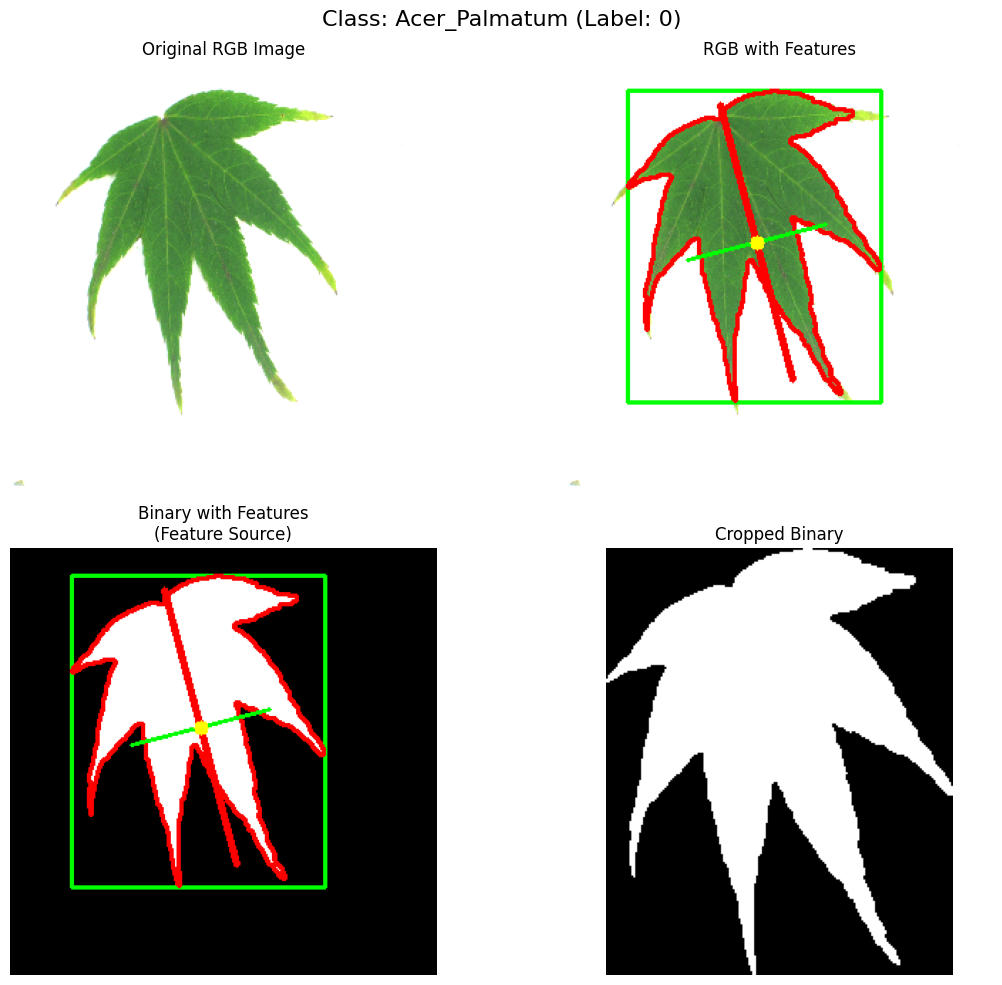

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,219.596802,178.559341,178.0,219.0,15926.0,1182.714844,0.812785,0.143073,2.447695,6.644465,0.000821,4.088961e-08,4.356074e-11,2.586440e-11,8.673062e-22,4.284754e-15,-3.855395e-23


------------------------------------------------------------------------------------------------------------------------

Image: 2366.jpg


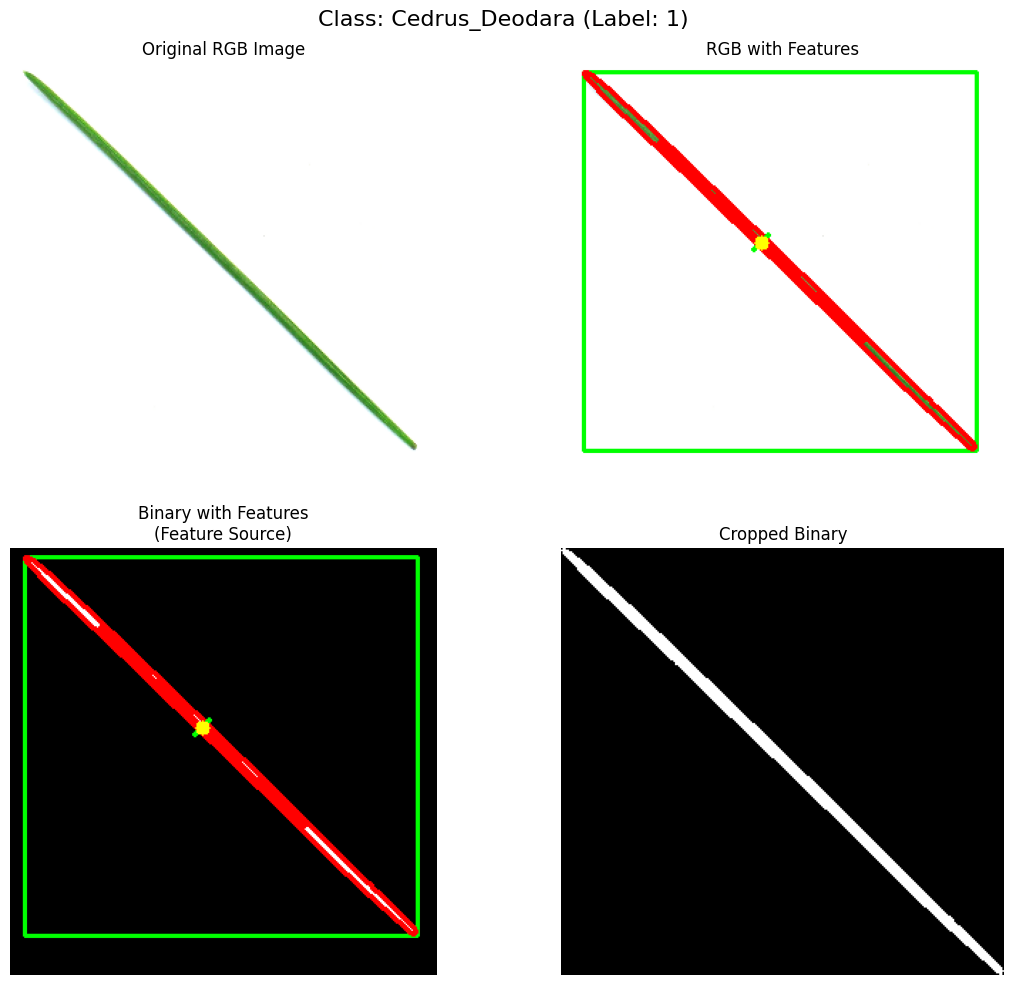

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,380.485901,8.186623,276.0,266.0,2381.0,773.047913,1.037594,0.050068,30.834103,2.800898,0.016382,0.000268,9.100120e-09,8.868544e-09,7.967124e-17,1.444008e-10,-1.134944e-19


------------------------------------------------------------------------------------------------------------------------

Image: 1142.jpg


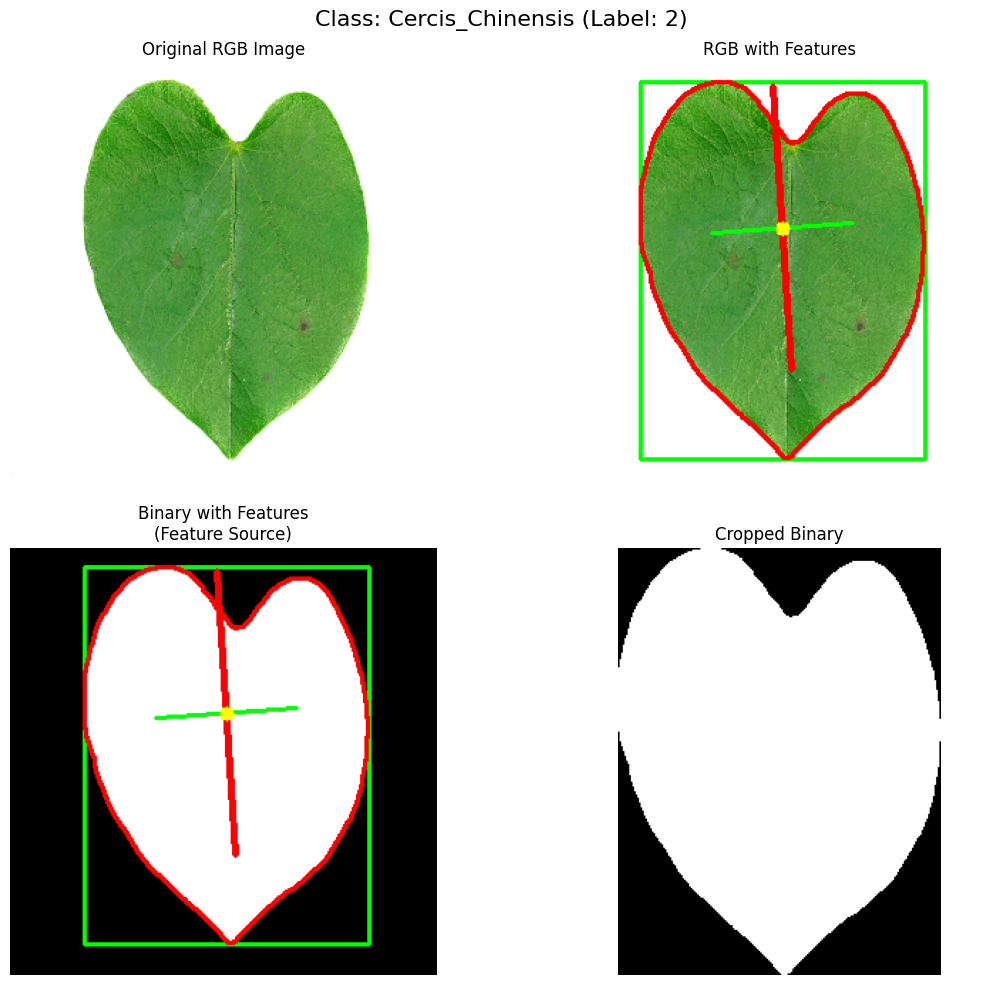

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,266.822327,199.044495,200.0,265.0,37702.5,804.447815,0.754717,0.732123,1.405742,4.022239,0.000661,1.797669e-08,1.728103e-11,2.237685e-14,-3.795178e-28,-2.681431e-18,1.390982e-26


------------------------------------------------------------------------------------------------------------------------

Image: 3585.jpg


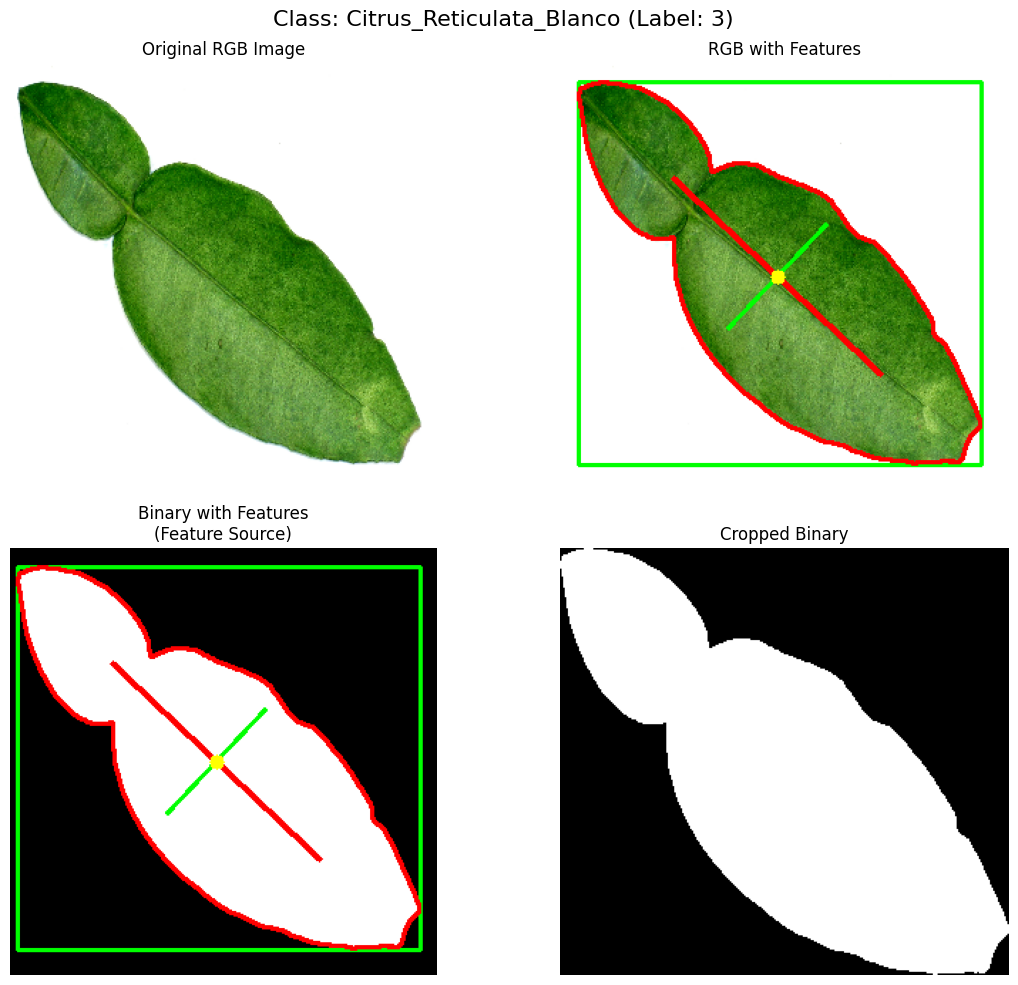

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,373.386688,140.249268,283.0,269.0,34809.0,915.317871,1.052045,0.522105,2.186992,3.234339,0.001021,6.227016e-07,5.820892e-11,2.785879e-11,1.121697e-21,2.179825e-14,-1.902904e-23


------------------------------------------------------------------------------------------------------------------------

Image: 2443.jpg


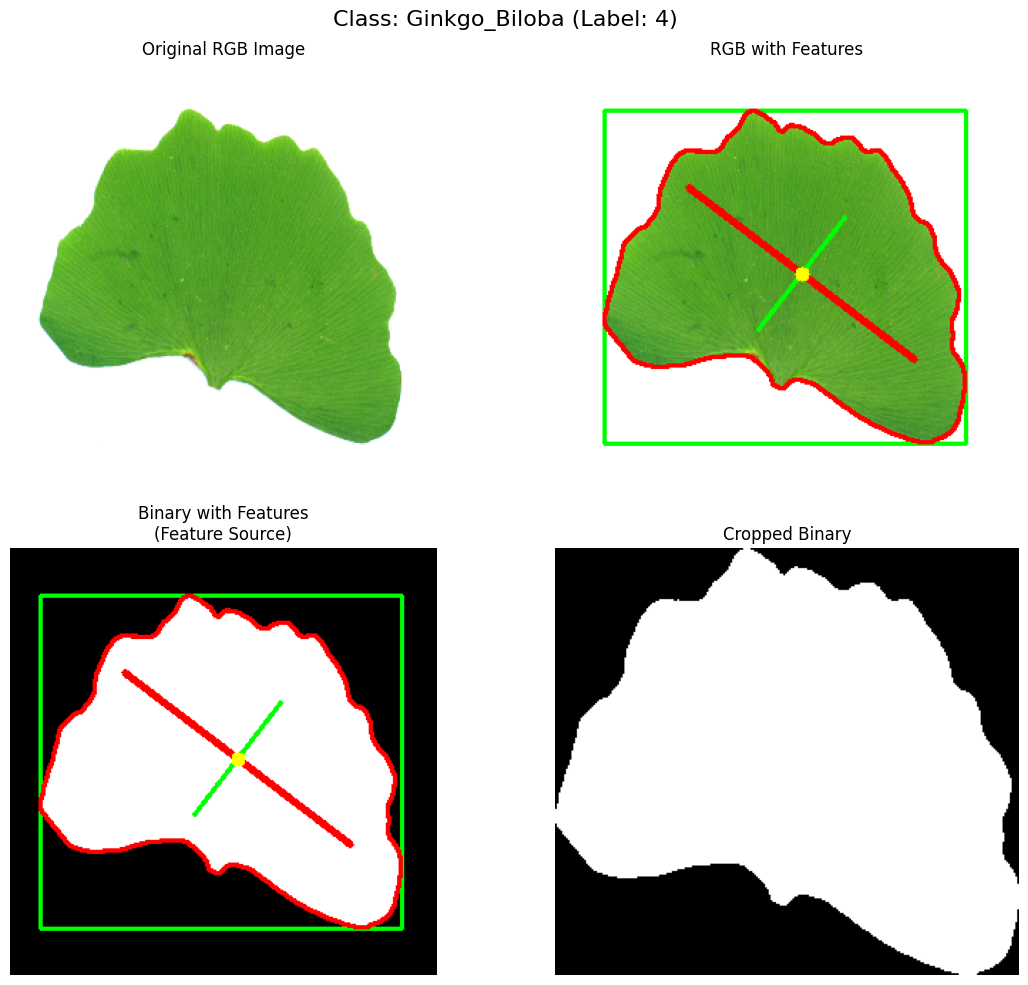

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,270.902832,222.153259,254.0,234.0,37503.5,856.163574,1.08547,0.642937,1.584812,3.370723,0.000713,5.077336e-08,7.018871e-11,3.524215e-12,-2.292659e-23,-3.053165e-16,-5.046392e-23


------------------------------------------------------------------------------------------------------------------------

Image: 3530.jpg


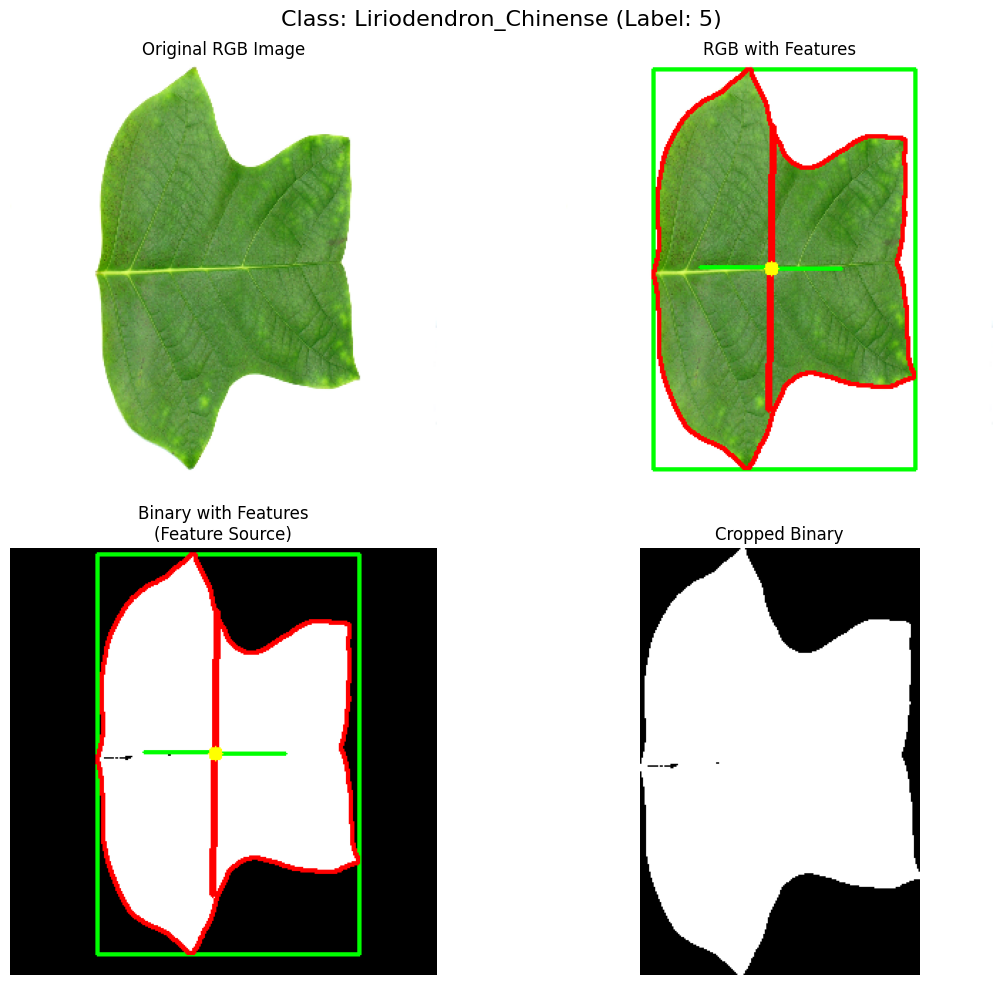

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,280.024536,184.437881,184.0,281.0,33870.0,867.411255,0.654804,0.565685,1.526543,4.714191,0.000702,2.243684e-08,3.221616e-11,1.100099e-13,-2.069851e-25,-1.626114e-17,-6.965338e-27


------------------------------------------------------------------------------------------------------------------------

Image: 2566.jpg


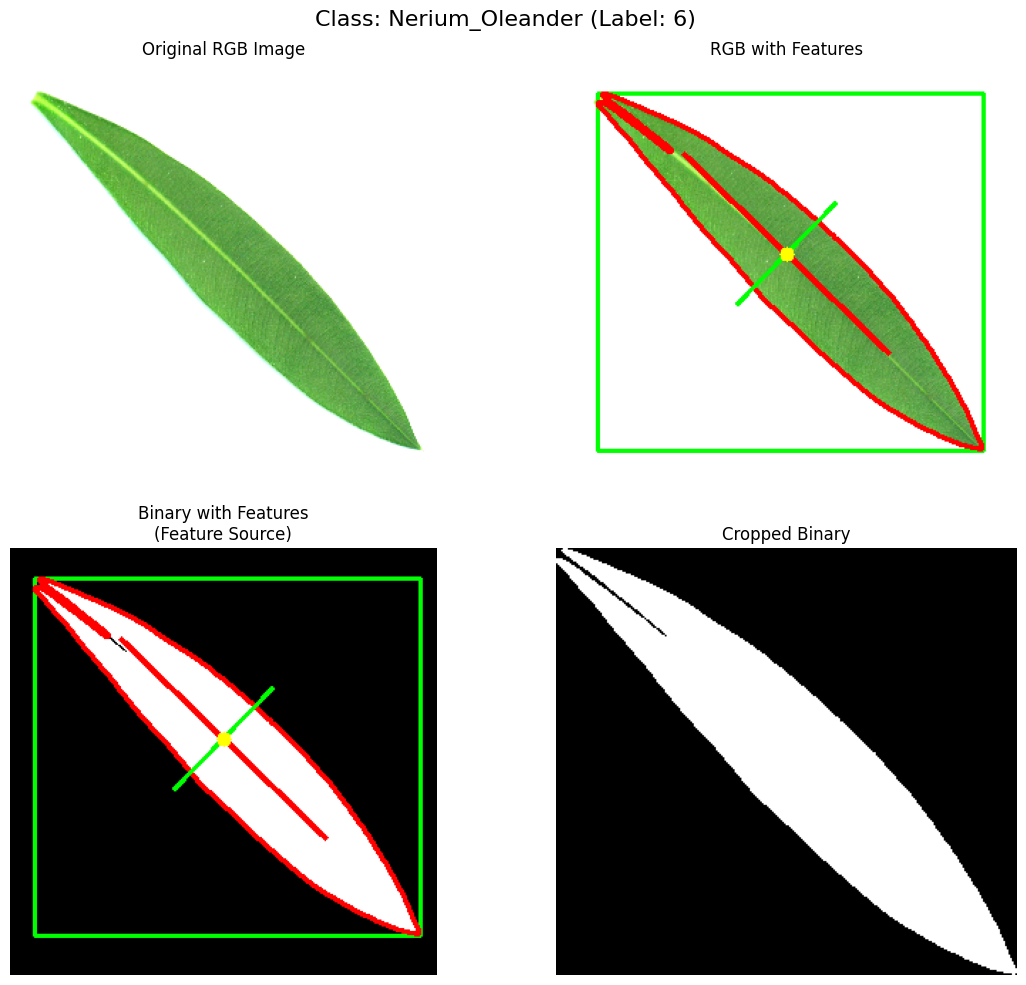

Features extracted from BINARY image:


,major_axis,minor_axis,bbox_w,bbox_h,area,perimeter,aspect_ratio,form_factor,rectangularity,per_diam_ratio,hu1,hu2,hu3,hu4,hu5,hu6,hu7
0,364.31012,66.829132,271.0,251.0,16807.5,914.520996,1.079681,0.252537,4.047062,3.374616,0.001725,0.000003,5.206636e-11,3.081113e-11,1.226878e-21,4.352029e-14,1.330431e-22


------------------------------------------------------------------------------------------------------------------------


In [10]:
data_path = "img_data/data"
visualize_dataset_features(data_path, n_per_class=1)